
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./GreatCellHM_VPF_propagating.ipynb" download="GreatCellHM_VPF_propagating.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=GreatCellHM_VPF_propagating.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating.py"><img src="https://img.shields.io/static/v1?label=Source:&message=GreatCellHM_VPF_propagating.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/master?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating.py%26branch=master%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>



In [1]:
import os
import shutil
import sys
import xml.etree.ElementTree as ET
from pathlib import Path
from subprocess import run

import matplotlib as mpl
import matplotlib.pyplot as plt
import meshio
import numpy as np
import ogstools as ot
import pyvista as pv
from matplotlib import colormaps

mechanics_path = Path(
    "..", "..", "LIE", "Mechanics", "GreatCelljupyterNotebook"
).resolve()
sys.path.insert(0, str(mechanics_path))
# Local modules
from mesh_generator import (  # noqa: E402
    mesh_GreatCell_Borehole_VPF,
)
from ogs_model_runner import SingleOGSModel  # noqa: E402
from Plotter import Plotter  # noqa: E402

In [2]:
def truncated_cmap(name, minval=0.3, maxval=0.9, n=6):
    base = colormaps.get_cmap(name)
    return lambda i: base(minval + (maxval - minval) * i / (n - 1))


mpl.rcdefaults()
mpl.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": ["DejaVu Serif"],
        "axes.labelsize": 26,
        "axes.titlesize": 24,
        "legend.fontsize": 18,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
    }
)

In [3]:
ot.plot.setup.show_region_bounds = False

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

# Great cell
## $\texttt{HM}_{3d}$: Fracture Nucleation from Borehole under Poly-Axial Stress

The **$\texttt{HM}_{3d}$** benchmark simulates **fracture nucleation** directly from a borehole in an intact rock sample subjected to **poly-axial stress conditions**.

Fluid is injected at a rate of:

$$
Q_0 = 2 \times 10^{-7} \times 2\pi r \quad \text{m}^2/\text{s}, \quad \text{with } r = 0.005\,\text{m}.
$$


This test provides insight into fluid-driven fracture processes under realistic in situ conditions and is especially useful for validating **coupled hydro-mechanical models**.

 **For full details**, visit the GREAT Cell benchmark page:
[https://www.opengeosys.org/docs/benchmarks/small-deformation/greatcell](https://www.opengeosys.org/docs/benchmarks/small-deformation/greatcell)

To run this benchmark, you need to have OGS built with PETSc and PIP support. The following steps outline the process:
1. **Configure & build OGS with PETSc & PIP**
   ```bash
   cmake -S ogs-source -B build-folder --preset release-petsc \
     -DOGS_USE_PETSC=ON \
     -DOGS_USE_PIP=ON
   ```

2. **Run the benchmark**

   ```bash
   cd build-folder/release-petsc
   ctest -R nb-HMPhaseField/GreatCell
   ```

3. **Verify output files**

   ```bash
   ls build-folder/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCell
   ```

---
## Material Properties


The material properties are provided in the following dictionary. The computational model incorporates two distinct elastic materials within its domain: a central circle ($r=0.097$ m) of rock surrounded by a rubber sheath in a 2D configuration.


In [4]:
materials = {
    "Gneiss": {
        "young_sample": 83.9e9,  # Young's modulus (Pa)
        "nu_sample": 0.21,  # Poisson's ratio
        "biot": 0.6,  # Biot coefficient
        "porosity": 0.001,  # Porosity
        "permeability": 1e-19,  # Permeability (m²)
        "density_solid": 2750,  # Solid density (kg/m³)
        "k_n": 200e9,  # Normal stiffness (Pa/m)
        "k_t": 100e9,  # Tangential stiffness (Pa/m)
        "c_f": 4.4e-10,  # Fluid compressibility (Pa⁻¹)
        "k_s": 4.82e10,  # Solid bulk modulus (Pa)
        "S_f": 4.4e-10,  # Specific storage (Pa⁻¹)
        "t_np": 10e6,  # Peak normal traction (Pa)
        "Gc": 59.375,  # Fracture toughness (J/m²)
        "w_init": 1e-6,  # initial fracture width (m)
        "fluid": {
            "density": 1000.0,  # Fluid density (kg/m³)
            "viscosity": 1e-3,  # Fluid viscosity (Pa·s)
            "injectionFlowRate_Inlet": 3.75e-7,  # Injection flow rate (m³/s)
            "p_outlet": 3.45e6,  # Outlet pressure (Pa)
        },
        "rubber_sheath": {
            "young_modulus": 83.9e9,  # Young's modulus (Pa)
            "poisson_ratio": 0.21,  # Poisson's ratio
            "porosity": 0.001,  # Porosity
            "permeability": 1e-19,  # Permeability (m²)
            "density": 2750,  # Density (kg/m³)
            "biot": 0.6,  # Biot coefficient
        },
    },
    # "Greywacke": {
    #     "young_sample": 26.87e9,  # Young's modulus (Pa)
    #     "nu_sample": 0.27,  # Poisson's ratio
    #     "biot": 0.8,  # Biot coefficient
    #     "porosity": 0.005,  # Porosity
    #     "permeability": 2.58e-19,  # Permeability (m²)
    #     "density_solid": 2650,  # Solid density (kg/m³)
    #     "k_n": 100e9,  # Normal stiffness (Pa/m)
    #     "k_t": 50e9,  # Tangential stiffness (Pa/m)
    #     "c_f": 4.4e-10,  # Fluid compressibility (Pa⁻¹)
    #     "k_s": 1.95e10,  # Solid bulk modulus (Pa)
    #     "S_f": 4.4e-10,  # Specific storage (Pa⁻¹)
    #     "t_np": 10e6,  # Peak normal traction (Pa)
    #     "Gc": 35.65,  # Fracture toughness (J/m²)
    #     "w_init": 1e-6,  # initial fracture width (m)
    #     "fluid": {
    #         "density": 1000.0,  # Fluid density (kg/m³)
    #         "viscosity": 1.0e-3,  # Fluid viscosity (Pa·s)
    #         "injectionFlowRate_Inlet": 3.75e-7,  # 1.75e-7,  # Injection flow rate (m³/s)
    #         "p_outlet": 3.45e6,  # Outlet pressure (Pa)
    #     },
    #     "rubber_sheath": {
    #         "young_modulus": 26.87e9,  # Young's modulus (Pa)
    #         "poisson_ratio": 0.27,  # Poisson's ratio
    #         "porosity": 0.005,  # Porosity
    #         "permeability": 2.58e-19,  # Permeability (m²)
    #         "density": 2650,  # Density (kg/m³)
    #         "biot": 0.8,  # Biot coefficient
    #     },
    # },
}

material_names = list(materials.keys())

To run the benchmark with Greywacke, uncomment the "Greywacke" section in the `materials` dictionary above, also it suggested to use finer mesh size `h=0.001` for Greywacke.

---
# Loads



### Table: Load Conditions

| Marker | PEE1 Angle to $\sigma_2$ | PEE1 & 1a | PEE2 & 2a | PEE3 & 3a | PEE4 & 4a | PEE5 & 5a | PEE6 & 6a | PEE7 & 7a | PEE8 & 8a |
|--------|--------------------------|----------|----------|----------|----------|----------|----------|----------|----------|
| A      | 0°                       | 10.0     | 6.64     | 4.46     | 1.17     | 1.0      | 3.82     | 7.80     | 9.95     |
| B      | 45.0°                    | 7.80     | 9.95     | 10.0     | 6.64     | 4.46     | 1.17     | 1.0      | 3.82     |
| C      | 90°                      | 1.0      | 3.82     | 7.80     | 9.95     | 10.0     | 6.64     | 4.46     | 1.17     |

*All loads are in MPa. DSS loads are averages of adjacent PEEs.*

### Schematic loading conditions

In [5]:
loads = {
    "A": [
        10.0e6,
        6.64e6,
        4.46e6,
        1.17e6,
        1.0e6,
        3.82e6,
        7.80e6,
        9.95e6,
        10.0e6,
        6.64e6,
        4.46e6,
        1.17e6,
        1.0e6,
        3.82e6,
        7.80e6,
        9.95e6,
    ],
    "B": [
        7.80e6,
        9.95e6,
        10.0e6,
        6.64e6,
        4.46e6,
        1.17e6,
        1.0e6,
        3.82e6,
        7.80e6,
        9.95e6,
        10.0e6,
        6.64e6,
        4.46e6,
        1.17e6,
        1.0e6,
        3.82e6,
    ],
    "C": [
        1.0e6,
        3.82e6,
        7.80e6,
        9.95e6,
        10.0e6,
        6.64e6,
        4.46e6,
        1.17e6,
        1.0e6,
        3.82e6,
        7.80e6,
        9.95e6,
        10.0e6,
        6.64e6,
        4.46e6,
        1.17e6,
    ],
}

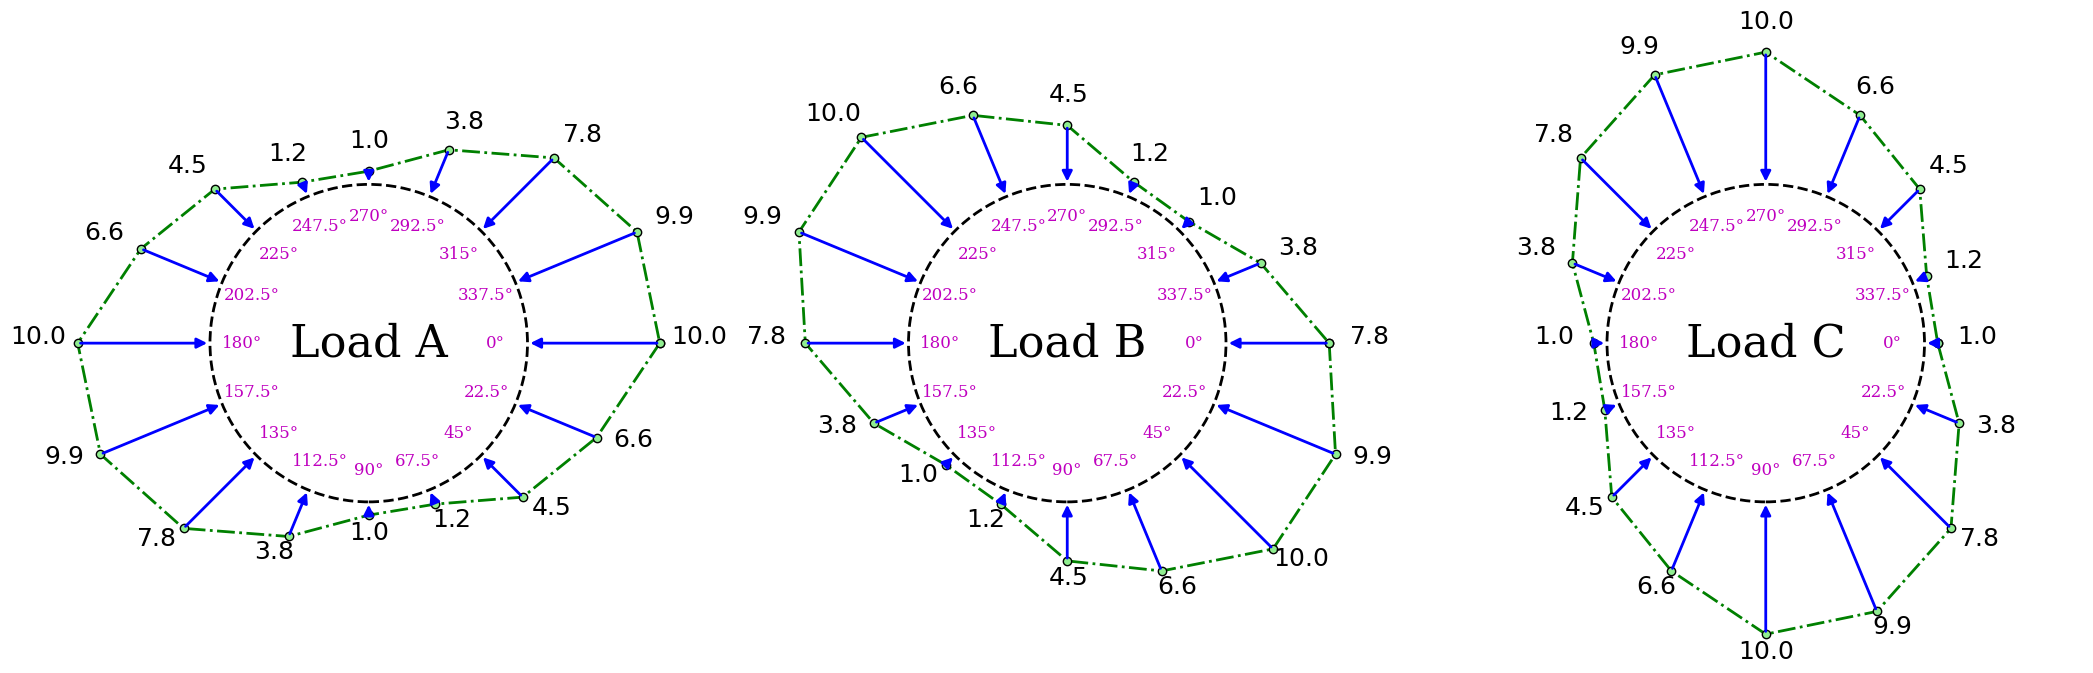

In [6]:
angles_degrees = [
    0,
    -22.5,
    -45,
    -67.5,
    -90,
    -112.5,
    -135,
    -157.5,
    -180,
    -202.5,
    -225,
    -247.5,
    -270,
    -292.5,
    -315,
    -337.5,
]
angles_radians = np.deg2rad(angles_degrees)
circle_radius = 6
circle_x = circle_radius * np.cos(angles_radians)
circle_y = circle_radius * np.sin(angles_radians)


fig, axs = plt.subplots(1, 3, figsize=(21, 7), facecolor="none")

for idx, (label, values) in enumerate(loads.items()):
    ax = axs[idx]
    ax.set_aspect("equal")
    ax.axis("off")

    formatted_values = [rf"${v / 1e6:.1f}$" for v in values]
    scaled_values = [v / 2 for v in values]

    circle = plt.Circle(
        (0, 0),
        circle_radius,
        color="black",
        fill=False,
        linestyle="--",
        linewidth=2,
    )
    ax.add_artist(circle)

    top_points_x, top_points_y = [], []

    for i, (x, y, value) in enumerate(
        zip(circle_x, circle_y, scaled_values, strict=False)
    ):
        unit_vector = np.array([x, y]) / circle_radius
        line_end = np.array([x, y]) + unit_vector * value / 1e6

        top_points_x.append(line_end[0])
        top_points_y.append(line_end[1])

        ax.annotate(
            "",
            xytext=line_end,
            xy=(x, y),
            arrowprops={
                "arrowstyle": "-|>",
                "color": "blue",
                "lw": 2,
                "mutation_scale": 15,
                "fill": True,
            },
        )

        angle_offset = 1.2 * unit_vector
        angle_label = f"{-angles_degrees[i]}°"
        ax.text(
            x - angle_offset[0],
            y - angle_offset[1],
            angle_label,
            fontsize=12,
            ha="center",
            va="center",
            color="m",
        )

        value_offset = 0.5 * unit_vector
        ax.text(
            line_end[0] + 3.0 * value_offset[0],
            line_end[1] + 1.8 * value_offset[1],
            formatted_values[i],
            fontsize=18,
            ha="center",
            weight="bold",
        )

    top_points_x.append(top_points_x[0])
    top_points_y.append(top_points_y[0])
    ax.plot(
        top_points_x,
        top_points_y,
        color="green",
        linestyle="-.",
        lw=2,
        marker="o",
        markersize=6,
        markerfacecolor="lightgreen",
        markeredgewidth=1.0,
        markeredgecolor="black",
    )

    ax.set_xlim([-12, 12])
    ax.set_ylim([-12, 12])

    ax.text(
        0,
        0,
        f"Load {label}",
        fontsize=32,
        ha="center",
        va="center",
        family="serif",
    )

plt.tight_layout()
output_path = Path(out_dir, "loads_A_B_C_schematic_with_angles.png")
plt.savefig(output_path, dpi=350, bbox_inches="tight", transparent=True)
plt.show()

---

## Boundary Conditions

The boundary conditions applied in the simulation include both Dirichlet and Neumann conditions.

- **Dirichlet conditions** (displacement control):
\[
\begin{cases}
u_y(x, 0) = 0,  & \quad \text{for } x = \pm 0.09894~\text{m} \quad (\text{left and right points boundaries}), \\
u_x(0, y) = 0,  & \quad \text{for } y = \pm 0.09894~\text{m} \quad (\text{top and bottom points boundaries}), \\
u_x = u_y = 0,  & \quad \text{on } x^2 + y^2 = r_{\text{borehole}}^2
\end{cases}
\]

- **Neumann conditions**:
  Normal stress $\sigma_{rr}$ is applied on PEEs and DSSs. The DSS stress is calculated as:
  $$\sigma_\text{DSS}^i = \frac{\sigma_\text{PEE}^i + \sigma_\text{PEE}^{i+1}}{2}$$

---
# Mesh generation of intact samples

### Input

In [7]:
h = 0.001
borehole_radius = 0.0025
delta = 0.00025
meshname = "GreatCell"
mesh_path = Path(out_dir, "mesh_borehole").resolve()
print(mesh_path)

/var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole


### Boundary meshes

#### Gmsh

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 10%] Meshing curve 2 (Circle)
Info    : [ 10%] Meshing curve 3 (Circle)
Info    : [ 10%] Meshing curve 4 (Circle)
Info    : [ 10%] Meshing curve 69 (Circle)
Info    : [ 10%] Meshing curve 70 (Circle)
Info    : [ 10%] Meshing curve 71 (Circle)
Info    : [ 10%] Meshing curve 72 (Circle)
Info    : [ 10%] Meshing curve 73 (Circle)
Info    : [ 20%] Meshing curve 74 (Circle)
Info    : [ 20%] Meshing curve 75 (Circle)
Info    : [ 20%] Meshing curve 76 (Circle)
Info    : [ 20%] Meshing curve 101 (Line)
Info    : [ 20%] Meshing curve 102 (Line)
Info    : [ 20%] Meshing curve 103 (Line)
Info    : [ 20%] Meshing curve 104 (Line)
Info    : [ 20%] Meshing curve 105 (Line)
Info    : [ 30%] Meshing curve 106 (Line)
Info    : [ 30%] Meshing curve 107 (Line)
Info    : [ 30%] Meshing curve 108 (Line)
Info    : [ 30%] Meshing curve 109 (Line)
Info    : [ 30%] Meshing curve 110 (Line)
Info    : [ 30%] Meshing curve 111 (Line)
In

Info    : [ 50%] Meshing surface 3 (Plane, Delaunay)


Info    : [ 70%] Meshing surface 4 (Plane, Delaunay)
Info    : [ 90%] Meshing surface 5 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 2.61205s, CPU 2.61099s)
Info    : 21558 nodes 43791 elements
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Delaunay)
Info    : [ 30%] Meshing surface 2 (Plane, Delaunay)


Info    : [ 50%] Meshing surface 3 (Plane, Delaunay)


Info    : [ 70%] Meshing surface 4 (Plane, Delaunay)
Info    : [ 90%] Meshing surface 5 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 2.63085s, CPU 2.6302s)
Info    : 21558 nodes 43791 elements
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Delaunay)
Info    : [ 30%] Meshing surface 2 (Plane, Delaunay)


Info    : [ 50%] Meshing surface 3 (Plane, Delaunay)


Info    : [ 70%] Meshing surface 4 (Plane, Delaunay)
Info    : [ 90%] Meshing surface 5 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 2.61897s, CPU 2.61632s)
Info    : 21558 nodes 43791 elements
Info    : Writing '/var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/GreatCell.msh'...
Info    : Done writing '/var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/GreatCell.msh'



Saved: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/domain.vtu (112 cells)
Saved: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/physical_group_p_right.vtu (1 cells)
Saved: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/physical_group_p_top.vtu (1 cells)
Saved: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/physical_group_p_left.vtu (1 cells)
Saved: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/physical_group_p_bottom.vtu (1 cells)
Saved: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseF

2025-09-18 13:50:11.033 (  11.144s) [    79053505CB80]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


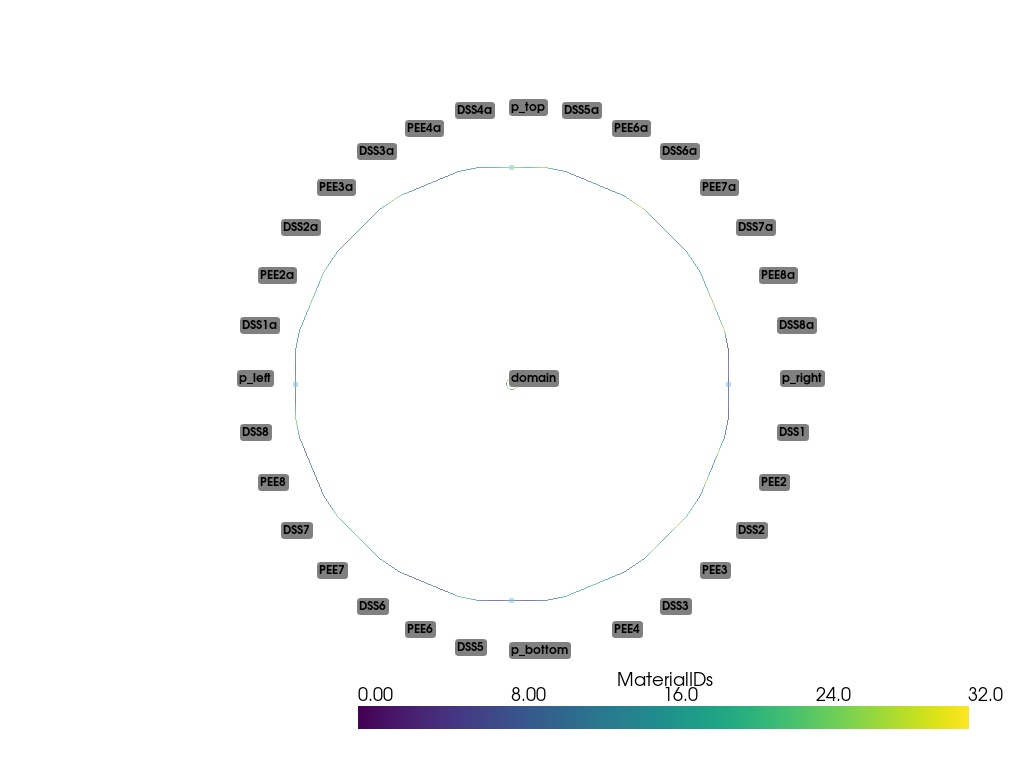

In [8]:
msh_file = mesh_GreatCell_Borehole_VPF(
    lc=0.0075,
    h=h,
    lc1=h,
    r0=0.097,
    r1=0.090,
    r2=0.065,
    borehole_radius=borehole_radius,
    delta=delta,
    out_dir=mesh_path,
    meshname=meshname,
    mode="BC",
    post_process=True,
    cmap="viridis",
    opacity=0.8,
)

### Computational domain mesh
#### Gmsh

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 10%] Meshing curve 2 (Circle)
Info    : [ 10%] Meshing curve 3 (Circle)
Info    : [ 10%] Meshing curve 4 (Circle)
Info    : [ 10%] Meshing curve 69 (Circle)
Info    : [ 10%] Meshing curve 70 (Circle)
Info    : [ 10%] Meshing curve 71 (Circle)
Info    : [ 10%] Meshing curve 72 (Circle)
Info    : [ 10%] Meshing curve 73 (Circle)
Info    : [ 20%] Meshing curve 74 (Circle)
Info    : [ 20%] Meshing curve 75 (Circle)
Info    : [ 20%] Meshing curve 76 (Circle)
Info    : [ 20%] Meshing curve 101 (Line)
Info    : [ 20%] Meshing curve 102 (Line)
Info    : [ 20%] Meshing curve 103 (Line)
Info    : [ 20%] Meshing curve 104 (Line)
Info    : [ 20%] Meshing curve 105 (Line)
Info    : [ 30%] Meshing curve 106 (Line)
Info    : [ 30%] Meshing curve 107 (Line)
Info    : [ 30%] Meshing curve 108 (Line)
Info    : [ 30%] Meshing curve 109 (Line)
Info    : [ 30%] Meshing curve 110 (Line)
Info    : [ 30%] Meshing curve 111 (Line)
In

Info    : [ 50%] Meshing surface 3 (Plane, Delaunay)


Info    : [ 70%] Meshing surface 4 (Plane, Delaunay)
Info    : [ 90%] Meshing surface 5 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 2.59943s, CPU 2.59887s)
Info    : 21558 nodes 43791 elements
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Delaunay)
Info    : [ 30%] Meshing surface 2 (Plane, Delaunay)


Info    : [ 50%] Meshing surface 3 (Plane, Delaunay)


Info    : [ 70%] Meshing surface 4 (Plane, Delaunay)
Info    : [ 90%] Meshing surface 5 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 2.60892s, CPU 2.60854s)
Info    : 21558 nodes 43791 elements
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Delaunay)
Info    : [ 30%] Meshing surface 2 (Plane, Delaunay)


Info    : [ 50%] Meshing surface 3 (Plane, Delaunay)


Info    : [ 70%] Meshing surface 4 (Plane, Delaunay)
Info    : [ 90%] Meshing surface 5 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 2.60709s, CPU 2.60663s)
Info    : 21558 nodes 43791 elements
Info    : Writing '/var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/GreatCell.msh'...
Info    : Done writing '/var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/GreatCell.msh'



Saved: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/domain.vtu (43002 cells)
Saved: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/physical_group_Weakzone_sample.vtu (36 cells)
Saved: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/physical_group_Central_sample.vtu (42618 cells)
Saved: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/physical_group_OuterPart_sample.vtu (3970 cells)
Saved: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/physical_group_Rubber_sheath.vtu (180 cells)


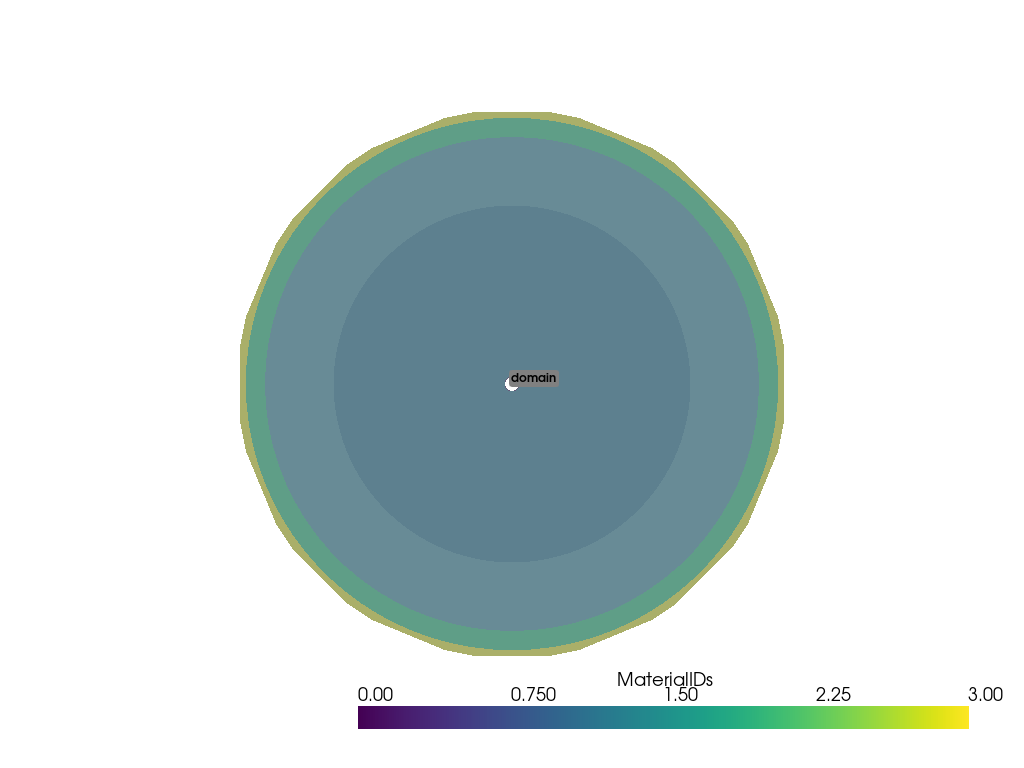

In [9]:
msh_file = mesh_GreatCell_Borehole_VPF(
    lc=0.0075,
    h=h,
    lc1=h,
    r0=0.097,
    r1=0.090,
    r2=0.065,
    borehole_radius=borehole_radius,
    delta=delta,
    out_dir=mesh_path,
    meshname=meshname,
    mode="domain",
    post_process=True,
    cmap="viridis",
    opacity=0.8,
)

In [10]:
mesh_dir = Path(mesh_path).resolve()

run(
    [
        "NodeReordering",
        "-i",
        str(mesh_dir.joinpath("domain.vtu")),
        "-o",
        str(mesh_dir.joinpath("domain.vtu")),
    ],
    cwd=mesh_dir,
    check=True,
)

physical_groups = [
    "physical_group_DSS1.vtu",
    "physical_group_DSS1a.vtu",
    "physical_group_DSS2.vtu",
    "physical_group_DSS2a.vtu",
    "physical_group_DSS3.vtu",
    "physical_group_DSS3a.vtu",
    "physical_group_DSS4.vtu",
    "physical_group_DSS4a.vtu",
    "physical_group_DSS5.vtu",
    "physical_group_DSS5a.vtu",
    "physical_group_DSS6.vtu",
    "physical_group_DSS6a.vtu",
    "physical_group_DSS7.vtu",
    "physical_group_DSS7a.vtu",
    "physical_group_DSS8.vtu",
    "physical_group_DSS8a.vtu",
    "physical_group_PEE1.vtu",
    "physical_group_PEE1a.vtu",
    "physical_group_PEE2.vtu",
    "physical_group_PEE2a.vtu",
    "physical_group_PEE3.vtu",
    "physical_group_PEE3a.vtu",
    "physical_group_PEE4.vtu",
    "physical_group_PEE4a.vtu",
    "physical_group_PEE5.vtu",
    "physical_group_PEE5a.vtu",
    "physical_group_PEE6.vtu",
    "physical_group_PEE6a.vtu",
    "physical_group_PEE7.vtu",
    "physical_group_PEE7a.vtu",
    "physical_group_PEE8.vtu",
    "physical_group_PEE8a.vtu",
    "physical_group_p_bottom.vtu",
    "physical_group_p_left.vtu",
    "physical_group_p_right.vtu",
    "physical_group_p_top.vtu",
    "physical_group_borehole_boundary.vtu",
]

group_paths = [str(mesh_dir.joinpath(name)) for name in physical_groups]

run(
    [
        "identifySubdomains",
        "-f",
        "-m",
        str(mesh_dir.joinpath("domain.vtu")),
        "--",
        *group_paths,
    ],
    cwd=mesh_dir,
    check=True,
)

[2025-09-18 13:50:24.067] [ogs] [info] Reordering nodes... 
[2025-09-18 13:50:24.068] [ogs] [info] Corrected 0 elements.
[2025-09-18 13:50:24.093] [ogs] [info] VTU file written.


[2025-09-18 13:50:25.485] [ogs] [info] Mesh reading time: 0.0524749 s
[2025-09-18 13:50:25.487] [ogs] [info] MeshNodeSearcher construction time: 0.00124748 s
[2025-09-18 13:50:25.487] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 1.3937e-05 s
[2025-09-18 13:50:25.487] [ogs] [info] There is already a 'bulk_node_ids' property present in the subdomain mesh 'physical_group_DSS1' and it is equal to the newly computed values.
[2025-09-18 13:50:25.489] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshElements took 0.00229027 s
[2025-09-18 13:50:25.489] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 1.382e-06 s
[2025-09-18 13:50:25.489] [ogs] [info] There is already a 'bulk_node_ids' property present in the subdomain mesh 'physical_group_DSS1a' and it is equal to the newly computed values.
[2025-09-18 13:50:25.490] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshElements took 0.0013348 s
[2025-09-18 13:50:25.490] [ogs] [info] 

CompletedProcess(args=['identifySubdomains', '-f', '-m', '/var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/domain.vtu', '--', '/var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/physical_group_DSS1.vtu', '/var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/physical_group_DSS1a.vtu', '/var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/physical_group_DSS2.vtu', '/var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole/physical_group_DSS2a.vtu', '/var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCel

Since the mesh may differ slightly depending on the operating system (macOS or Linux),
we use the following pre-existing mesh path for ctest.

In [11]:
mesh_path_pre_existing = Path("mesh_borehole_pre_existing").resolve()
# Compare generated and pre-existing meshes
meshes = {
    "mesh_path": pv.read(mesh_path.joinpath("domain.vtu")),
    "mesh_path_pre_existing": pv.read(mesh_path_pre_existing.joinpath("domain.vtu")),
}

for name, m in meshes.items():
    print(name, "Nodes:", m.n_points, "Elements:", m.n_cells)

d_nodes = meshes["mesh_path_pre_existing"].n_points - meshes["mesh_path"].n_points
d_cells = meshes["mesh_path_pre_existing"].n_cells - meshes["mesh_path"].n_cells
print("Δ Nodes:", d_nodes, " Δ Elements:", d_cells)

mesh_path_pre_existing_copy = (
    Path(out_dir).joinpath("mesh_borehole_pre_existing").resolve()
)

if mesh_path_pre_existing_copy.exists():
    shutil.rmtree(mesh_path_pre_existing_copy)

shutil.copytree(mesh_path_pre_existing, mesh_path_pre_existing_copy)

mesh_path Nodes: 21557 Elements: 43002
mesh_path_pre_existing Nodes: 4201 Elements: 8298
Δ Nodes: -17356  Δ Elements: -34704


PosixPath('/var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole_pre_existing')

---
# Intact rock sample with fluid injection ($\texttt{HM}_1$)

 This benchmark, which does not consider any fracture, is designed to verify the basic computational setting for hydro-mechanical simulations. In addition to the mechanical loads, a zero constant pore pressure is prescribed at the outer boundary. At the center of sample, fluid is injected at a rate of $Q_0^{\text{v}} = 2.085 \times 10^{-9}$ m$^3$/s

 The hydro-mechanical simulations follows a two-stage process: a 3000~s equilibrium phase under mechanical loading to stabilize initial conditions, followed by a 500~s fluid injection phase to model fluid flow. This loading condition is applied to both **Greywacke** and **Gneiss** samples


## Run the simulation
### Inputs

In [12]:
# Times for load curves
times = "0.0  500. 3500"
simulation_end_time = 3500.0
n_fracture_p_ncs = 3
model_type = "HM3d"
output_prefix = "HM3d_VPF"
# Load
PEE_load_values = {
    "A": [10.0e6, 6.64e6, 4.46e6, 1.17e6, 1.0e6, 3.82e6, 7.80e6, 9.95e6],
    "B": [7.80e6, 9.95e6, 10.0e6, 6.64e6, 4.46e6, 1.17e6, 1.0e6, 3.82e6],
    "C": [1.0e6, 3.82e6, 7.80e6, 9.95e6, 10.0e6, 6.64e6, 4.46e6, 1.17e6],
}

prj_file = Path("HM3d_VPF.prj")
prj = ot.Project(input_file=prj_file, output_file=Path(out_dir, f"{output_prefix}.prj"))

### Run OGS

In [13]:
# Create SingleOGSModel
sing_ogs_model = SingleOGSModel(
    model=prj,
    out_dir=out_dir,
    mesh_path=mesh_path_pre_existing_copy,
    output_prefix=output_prefix,
    method="VPF",
    n_fracture_p_ncs=n_fracture_p_ncs,
    model_type=model_type,
    materials=materials,
    n_mpi=4,
)

# Run simulations
vtu_files_dict_HM = sing_ogs_model.run_simulations_with_fracture(
    times=times,
    base_project_file=prj_file,
    mesh_path=mesh_path_pre_existing_copy,
    load_cases=PEE_load_values,
    material_names=material_names,
    materials=materials,
    n_fracture_p_ncs=n_fracture_p_ncs,
    model_type=model_type,
    output_prefix=output_prefix,
    out_dir=out_dir,
    method="VPF",
    fracture_model_type="VolumetricDeviatoric",
    mesh_size=h,
    delta=delta,
    borehole_r=borehole_radius,
    n_mpi=4,
)

mesh path: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole_pre_existing
[DEBUG] Current working directory: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/ogs/Tests/Data/HMPhaseField/GreatCell
[DEBUG] output project file: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/HM3d_VPF.prj
Modifying mesh for VPF method at /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole_pre_existing with crack type: full and h1: 0.001


info: Mesh 'domain' read: 4201 nodes, 8298 elements.
info: Write the mesh into METIS input file.
info: Total runtime: 0.0177325 s.
info: Total CPU time: 0.017721 s.


info: Mesh 'domain' read: 4201 nodes, 8298 elements.
info: METIS is running ...
info: Path to mpmetis is: 
	
info: Running: mpmetis -gtype=nodal "/var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole_pre_existing/domain.mesh" 4
******************************************************************************
METIS 5.2.1 Copyright 1998-22, Regents of the University of Minnesota
 (HEAD: unknown, Built on: Apr 23 2025, 08:49:08)
 size of idx_t: 64bits, real_t: 32bits, idx_t *: 64bits

Mesh Information ------------------------------------------------------------
 Name: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole_pre_existing/domain.mesh, #Elements: 8298, #Nodes: 4201, #Parts: 4

Options ---------------------------------------------------------------------
 ptype=kway, objtype=cut, ctype=shem, rtype=greedy, iptyp

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/HM3d_VPF_A.prj
Status: finished successfully.
Execution took 162.52901911735535 s
mesh path: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole_pre_existing
[DEBUG] Current working directory: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/ogs/Tests/Data/HMPhaseField/GreatCell
[DEBUG] output project file: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/HM3d_VPF_B.prj
Running simulation for load case: B with method: VPF, tension_cutoff: False

------------------------------------------------------------
* Running the simulation for sample Gneiss:
------------------------------------------------------------

DEBUG: Setting ls to 0.002 based on mesh size 0.0

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/HM3d_VPF_B.prj
Status: finished successfully.
Execution took 144.35320901870728 s
mesh path: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/mesh_borehole_pre_existing
[DEBUG] Current working directory: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/ogs/Tests/Data/HMPhaseField/GreatCell
[DEBUG] output project file: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/HM3d_VPF_C.prj
Running simulation for load case: C with method: VPF, tension_cutoff: False

------------------------------------------------------------
* Running the simulation for sample Gneiss:
------------------------------------------------------------

DEBUG: Setting ls to 0.002 based on mesh size 0.0

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-petsc/Tests/Data/HMPhaseField/GreatCell/GreatCellHM_VPF_propagating/HM3d_VPF_C.prj
Status: finished successfully.
Execution took 153.87949013710022 s


## Post-processing

### Profiles

Load: A, File 0, Benchmark: HM3d, Material: Gneiss


[2025-09-18 13:58:10.666] [ogs] [info] Reading meshes took 0.0130076 s
[2025-09-18 13:58:10.666] [ogs] [info] Collection of 8298 regular elements and computing element map took 0.00015028199999999985 s
[2025-09-18 13:58:10.666] [ogs] [info] Collection of 4542 nodes and computing offsets took 4.157999999998899e-06 s
[2025-09-18 13:58:10.668] [ogs] [info] Make nodes unique (4201 unique nodes) / computing map took 0.0018582579999999998 s
[2025-09-18 13:58:10.680] [ogs] [info] Reset nodes in regular elements took 0.012286700999999999 s
[2025-09-18 13:58:10.681] [ogs] [info] creation of merged mesh took 0.0009591619999999995 s
[2025-09-18 13:58:10.682] [ogs] [info] merge properties into merged mesh took 0.00039321399999999937 s
[2025-09-18 13:58:10.699] [ogs] [info] writing mesh took 0.016734624999999996 s


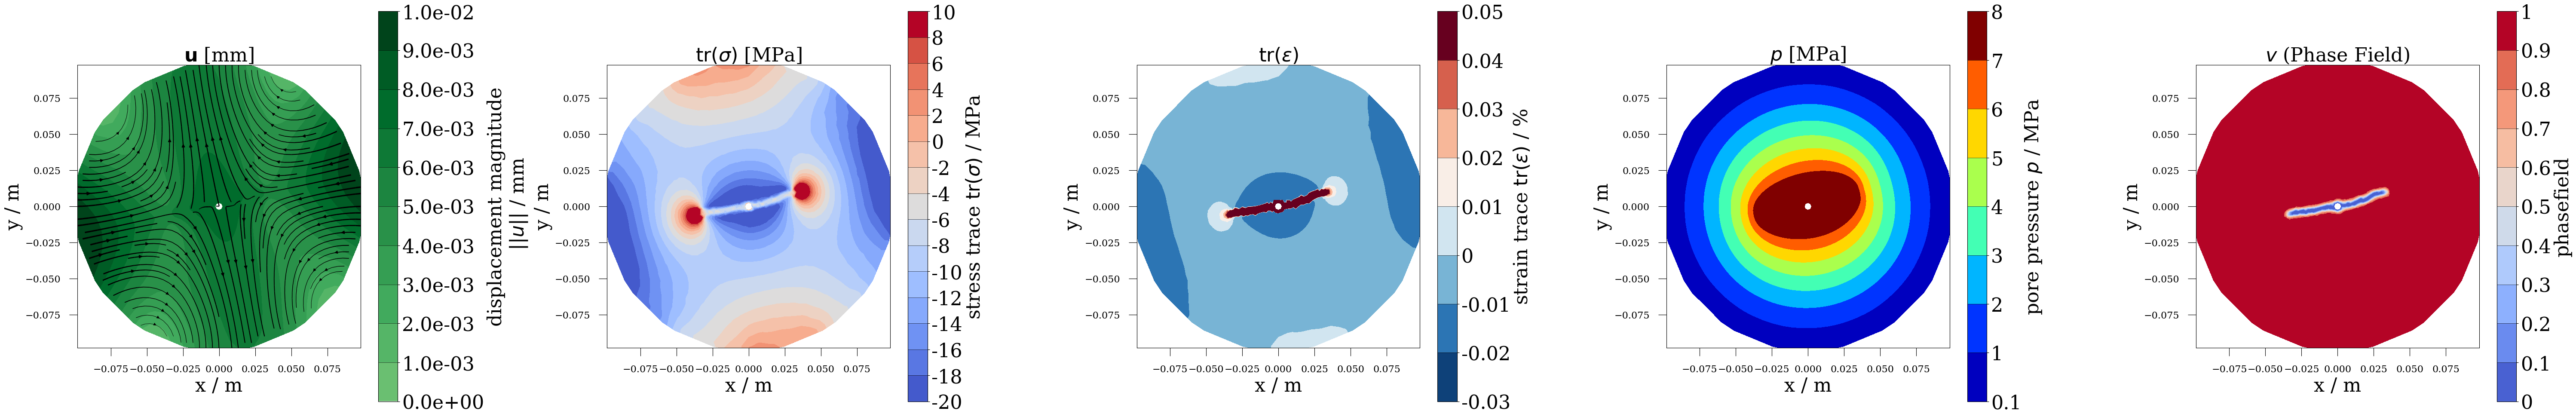

Load: B, File 0, Benchmark: HM3d, Material: Gneiss


[2025-09-18 13:58:13.973] [ogs] [info] Reading meshes took 0.013175015 s
[2025-09-18 13:58:13.973] [ogs] [info] Collection of 8298 regular elements and computing element map took 0.00015529199999999958 s
[2025-09-18 13:58:13.973] [ogs] [info] Collection of 4542 nodes and computing offsets took 4.148000000000693e-06 s
[2025-09-18 13:58:13.975] [ogs] [info] Make nodes unique (4201 unique nodes) / computing map took 0.0019293749999999988 s
[2025-09-18 13:58:13.988] [ogs] [info] Reset nodes in regular elements took 0.012137941999999999 s
[2025-09-18 13:58:13.988] [ogs] [info] creation of merged mesh took 0.0009684200000000011 s
[2025-09-18 13:58:13.989] [ogs] [info] merge properties into merged mesh took 0.00039183099999999874 s
[2025-09-18 13:58:14.004] [ogs] [info] writing mesh took 0.015359115 s


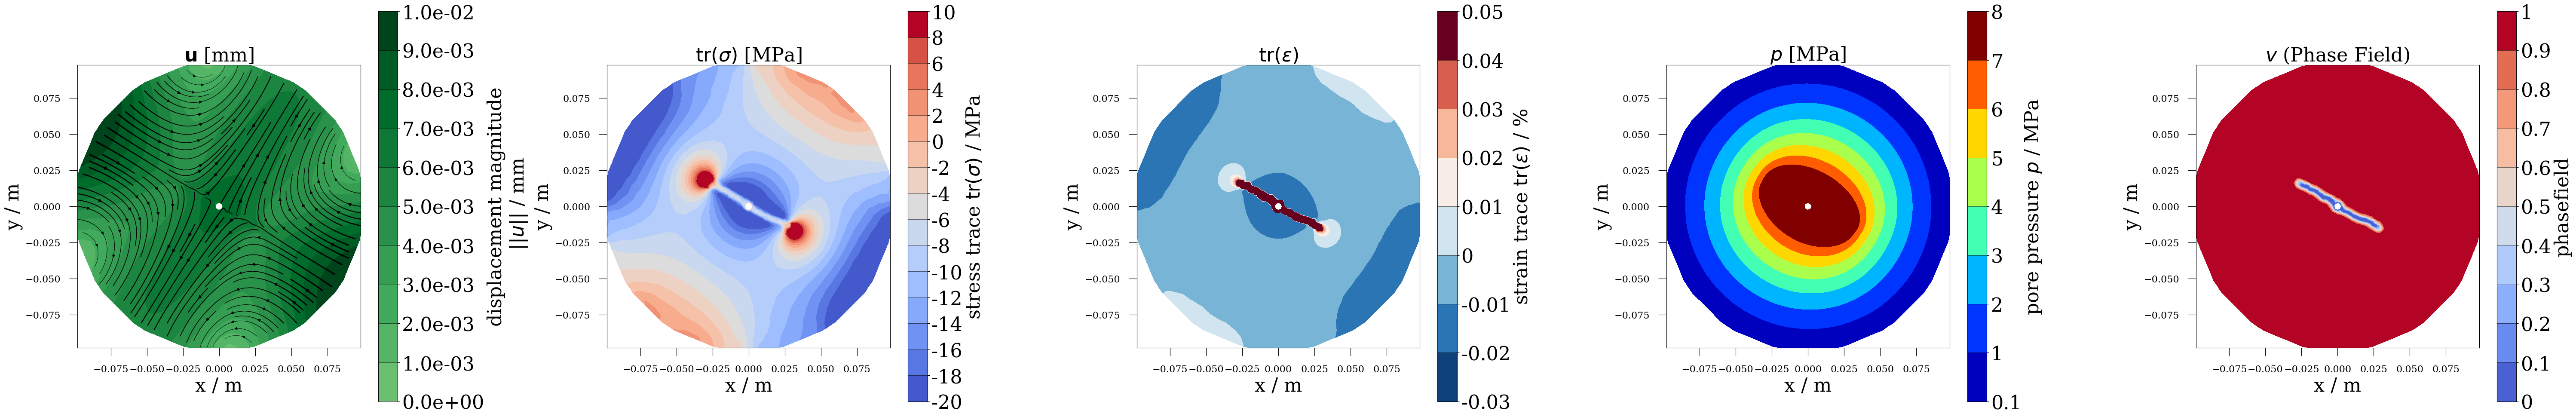

Load: C, File 0, Benchmark: HM3d, Material: Gneiss


[2025-09-18 13:58:17.430] [ogs] [info] Reading meshes took 0.013025836 s
[2025-09-18 13:58:17.430] [ogs] [info] Collection of 8298 regular elements and computing element map took 0.00015318699999999907 s
[2025-09-18 13:58:17.430] [ogs] [info] Collection of 4542 nodes and computing offsets took 4.278999999999394e-06 s
[2025-09-18 13:58:17.432] [ogs] [info] Make nodes unique (4201 unique nodes) / computing map took 0.0020712509999999996 s
[2025-09-18 13:58:17.444] [ogs] [info] Reset nodes in regular elements took 0.012007598999999999 s
[2025-09-18 13:58:17.445] [ogs] [info] creation of merged mesh took 0.0009663959999999978 s
[2025-09-18 13:58:17.445] [ogs] [info] merge properties into merged mesh took 0.0003947359999999997 s
[2025-09-18 13:58:17.463] [ogs] [info] writing mesh took 0.017142266999999996 s


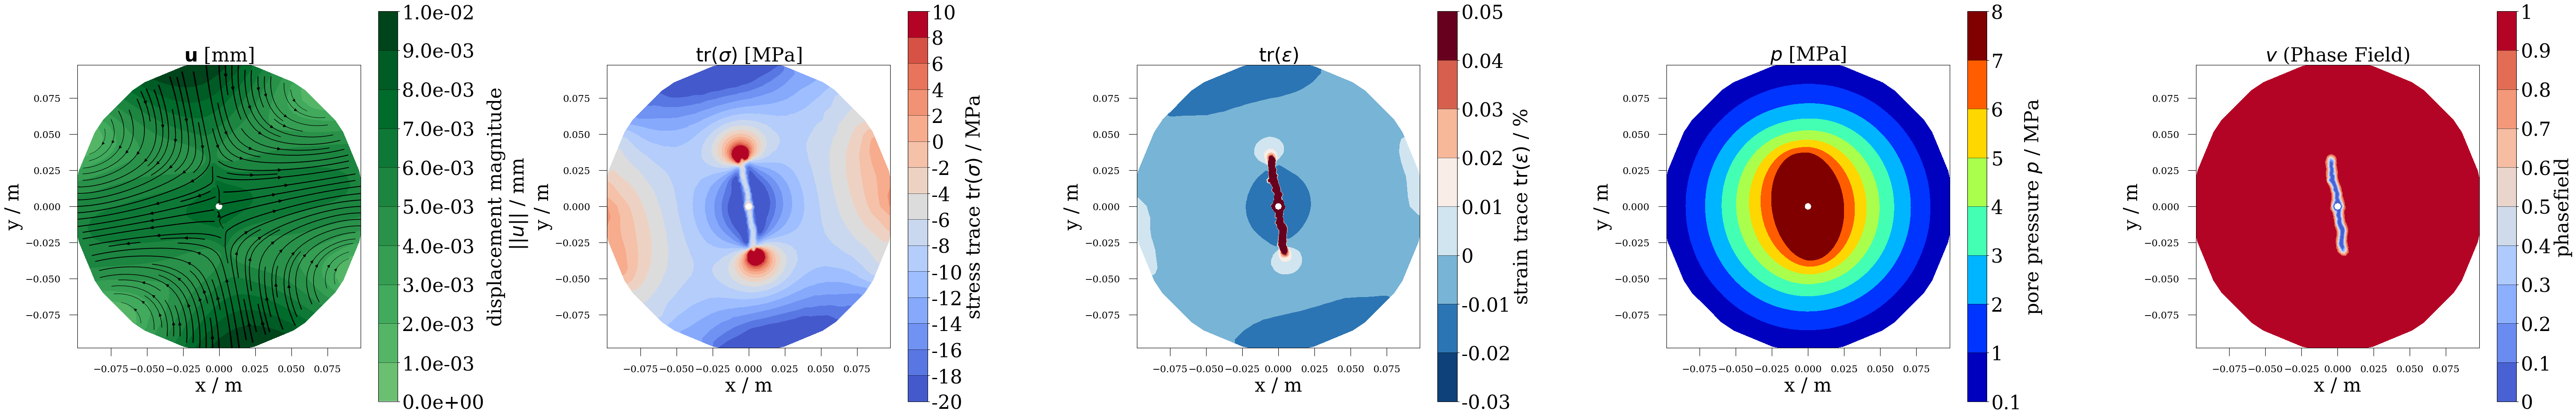

In [14]:

custom_cb = {
    "u": {"vmin": 0, "vmax": 1e-2, "cmap": "Greens"},
    "stress": {"vmin": -20, "vmax": 10, "cmap": "coolwarm"},
    "strain": {"vmin": -0.025, "vmax": 0.05, "cmap": "RdBu_r"},
    "pressure": {"vmin": 0.1, "vmax": 8, "cmap": "jet"},
}
plotter = Plotter(
    output_dir=out_dir,
    colorbar_opts=custom_cb,
    save_extracted_data=True,
)

plotter.plot_field_variables(vtu_files_dict_HM)

### Pressure over time at observation points

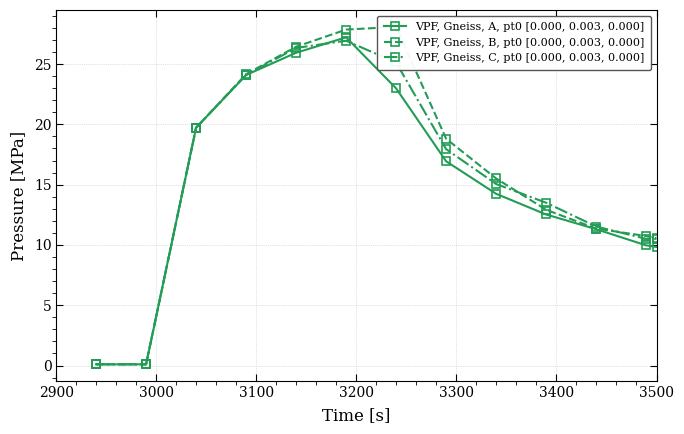

In [15]:

obs_points = {"pt0": np.array([[0.0, 0.0025, 0.0]])}
plotter.plot_observation_points_vs_time(
    vtu_files_dict_HM,
    obs_points,
    var=ot.variables.pressure,
    methods_to_include=["VPF"],
    time_min=2900,
    time_max=3500,
)

In [16]:
ref_base = "HM3d_VPF_A_Gneiss_ts_78_t_3500_000000"
expected_dir = Path("expected")
out_dir = Path(out_dir)
series_prefix = ref_base.split("_ts_")[0]
pvd_path = out_dir.joinpath(f"{series_prefix}.pvd")


def last_pvtu_from_series(pvd: Path, prefix: str) -> Path:
    ds = ET.parse(pvd).getroot().findall(".//DataSet")
    ds = [
        d
        for d in ds
        if d.attrib.get("file", "").startswith(prefix)
        and d.attrib["file"].endswith(".pvtu")
    ]
    ds.sort(key=lambda d: float(d.attrib.get("timestep", "0")))
    if not ds:
        msg = f"No matching DataSet for '{prefix}' in {pvd}"
        raise RuntimeError(msg)
    return (pvd.parent.joinpath(ds[-1].attrib["file"])).resolve()


ref_pvtu = expected_dir.joinpath(f"{ref_base}.pvtu")
ref_vtu = expected_dir.joinpath(f"{ref_base}.vtu")
run(["pvtu2vtu", "-i", str(ref_pvtu), "-o", str(ref_vtu)], check=True)

last_pvtu = last_pvtu_from_series(pvd_path, series_prefix)
last_vtu = last_pvtu.with_suffix(".vtu")
run(["pvtu2vtu", "-i", str(last_pvtu), "-o", str(last_vtu)], check=True)


# ---------------- VTU comparer ----------------
def read_mesh(path):
    m = meshio.read(str(path))
    pts = m.points.astype(float)
    if pts.shape[1] == 2:
        pts = np.c_[pts, np.zeros(len(pts))]
    return pts, m.point_data


def sort_index_by_points(pts):
    return np.lexsort((pts[:, 2], pts[:, 1], pts[:, 0]))


def reorder_point_data(pd, idx):
    out = {}
    for k, v in pd.items():
        arr = np.asarray(v)
        if arr.ndim == 1:
            arr = arr[:, None]
        out[k] = arr[idx]
    return out


def safe_max_rel_diff(a, b):
    denom = np.maximum(np.abs(b), 1e-12)
    return float(np.max(np.abs((a - b) / denom)))


def compare_arrays(a, b, rtol=1e-6, atol=1e-8, equal_nan=False):
    a = np.asarray(a)
    b = np.asarray(b)
    if a.ndim == 1:
        a = a[:, None]
    if b.ndim == 1:
        b = b[:, None]
    if a.shape != b.shape:
        return {"status": "SHAPE MISMATCH", "a_shape": a.shape, "b_shape": b.shape}
    try:
        np.testing.assert_allclose(a, b, rtol=rtol, atol=atol, equal_nan=equal_nan)
        return {"status": "MATCH"}
    except AssertionError:
        return {
            "status": "MISMATCH",
            "max_abs_diff": float(np.max(np.abs(a - b))),
            "max_rel_diff": safe_max_rel_diff(a, b),
            "count_not_close": int(
                np.sum(~np.isclose(a, b, rtol=rtol, atol=atol, equal_nan=equal_nan))
            ),
            "a_min": float(np.nanmin(a)),
            "a_max": float(np.nanmax(a)),
            "b_min": float(np.nanmin(b)),
            "b_max": float(np.nanmax(b)),
        }


def compare_vtu_files(
    fileA, fileB, array_names=None, rtol=1e-6, atol=1e-8, equal_nan=False
):
    ptsA, pdA = read_mesh(fileA)
    ptsB, pdB = read_mesh(fileB)

    if len(ptsA) != len(ptsB):
        return {
            "fatal": "Different point counts",
            "A_points": len(ptsA),
            "B_points": len(ptsB),
        }

    idxA = sort_index_by_points(ptsA)
    idxB = sort_index_by_points(ptsB)
    ptsA_sorted = ptsA[idxA]
    ptsB_sorted = ptsB[idxB]

    # looser atol for float noise in coordinates
    if not np.allclose(ptsA_sorted, ptsB_sorted, rtol=0.0, atol=1e-9):
        return {"fatal": "Point coordinate mismatch even after sorting"}

    pdA_sorted = reorder_point_data(pdA, idxA)
    pdB_sorted = reorder_point_data(pdB, idxB)

    if array_names is None:
        names = sorted(set(pdA_sorted.keys()) & set(pdB_sorted.keys()))
    else:
        names = [n for n in array_names if n in pdA_sorted and n in pdB_sorted]

    out = {"point_data": {}, "compared_arrays": names}
    for name in names:
        out["point_data"][name] = compare_arrays(
            pdA_sorted[name], pdB_sorted[name], rtol, atol, equal_nan
        )
    return out


res = compare_vtu_files(
    ref_vtu,
    last_vtu,
    array_names=["displacement"],
    rtol=1e-4,
    atol=1e-4,
    equal_nan=True,
)

for name, result in res["point_data"].items():
    assert result["status"] == "MATCH", f"Field '{name}' mismatch: {result}"

[2025-09-18 13:58:26.649] [ogs] [info] Reading meshes took 0.013119507 s
[2025-09-18 13:58:26.649] [ogs] [info] Collection of 8298 regular elements and computing element map took 0.0001551910000000007 s
[2025-09-18 13:58:26.649] [ogs] [info] Collection of 4546 nodes and computing offsets took 4.147999999998958e-06 s
[2025-09-18 13:58:26.651] [ogs] [info] Make nodes unique (4201 unique nodes) / computing map took 0.0018943669999999992 s
[2025-09-18 13:58:26.663] [ogs] [info] Reset nodes in regular elements took 0.012103063999999998 s
[2025-09-18 13:58:26.664] [ogs] [info] creation of merged mesh took 0.0009622879999999986 s
[2025-09-18 13:58:26.665] [ogs] [info] merge properties into merged mesh took 0.00042070699999999933 s
[2025-09-18 13:58:26.680] [ogs] [info] writing mesh took 0.015509337000000002 s


[2025-09-18 13:58:28.011] [ogs] [info] Reading meshes took 0.013113486 s
[2025-09-18 13:58:28.011] [ogs] [info] Collection of 8298 regular elements and computing element map took 0.00015360799999999952 s
[2025-09-18 13:58:28.011] [ogs] [info] Collection of 4542 nodes and computing offsets took 4.668999999998813e-06 s
[2025-09-18 13:58:28.013] [ogs] [info] Make nodes unique (4201 unique nodes) / computing map took 0.0018757110000000004 s
[2025-09-18 13:58:28.025] [ogs] [info] Reset nodes in regular elements took 0.012065109999999999 s
[2025-09-18 13:58:28.026] [ogs] [info] creation of merged mesh took 0.0009638910000000014 s
[2025-09-18 13:58:28.027] [ogs] [info] merge properties into merged mesh took 0.0003941750000000001 s
[2025-09-18 13:58:28.043] [ogs] [info] writing mesh took 0.016519217 s
